In [1]:
import respiration.dataset as repository

dataset = repository.from_default()

subject = 'Proband05'
scenario = '101_natural_lighting'

In [2]:
frames, meta = dataset.get_video_bgr(subject, scenario)

  0%|          | 0/3600 [00:00<?, ?it/s]

In [3]:
from respiration.extractor.mtts_can import preprocess_video_frames

resized, normalized = preprocess_video_frames(frames)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Normalized Frame')

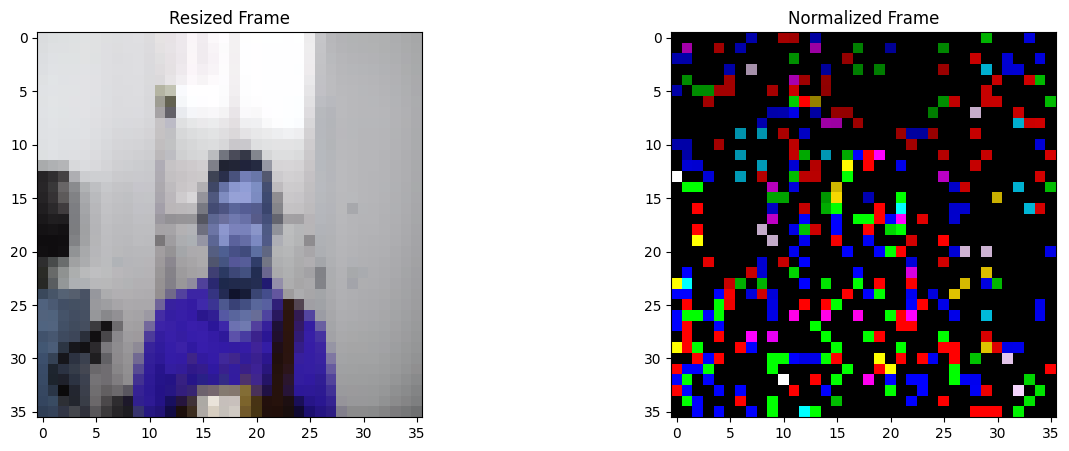

In [4]:
import matplotlib.pyplot as plt

# Plot resized and normalized frames
_, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(resized[0])
axs[0].set_title('Resized Frame')

axs[1].imshow(normalized[0])
axs[1].set_title('Normalized Frame')

In [5]:
# Save the normalized_frames as a video
# import cv2
# 
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('normalized_frames.avi', fourcc, 30.0, (36, 36))
# 
# for frame in normalized_frames:
#     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#     frame = (frame * 255).astype('uint8')  # Scale and convert to 8-bit
#     out.write(frame) 
#     
# out.release()

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

from respiration.extractor.mtts_can import load_model

frame_depth = 10

# The model expects a number of frames that is a multiple of frame_depth
cut_off = (normalized.shape[0] // frame_depth) * frame_depth
input_resized = resized[:cut_off]
input_normalized = normalized[:cut_off]

cut_off, frame_depth

(3590, 10)

In [7]:
input_resized.shape

(3590, 36, 36, 3)

In [8]:
model = load_model(frame_depth=frame_depth)
yptest = model.predict(
    (input_resized, input_normalized),
    batch_size=100
)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [9]:
import numpy as np
from respiration.preprocessing import detrend_tarvainen

pulse_pred = yptest[0]
pulse_pred = detrend_tarvainen(np.cumsum(pulse_pred), 100)
[b_pulse, a_pulse] = butter(1, [0.75 / meta.fps * 2, 2.5 / meta.fps * 2], btype='bandpass')
pulse_pred = filtfilt(b_pulse, a_pulse, np.double(pulse_pred))

resp_pred = yptest[1]
resp_pred = detrend_tarvainen(np.cumsum(resp_pred), 100)
[b_resp, a_resp] = butter(1, [0.08 / meta.fps * 2, 0.6 / meta.fps * 2], btype='bandpass')
resp_pred = filtfilt(b_resp, a_resp, np.double(resp_pred))

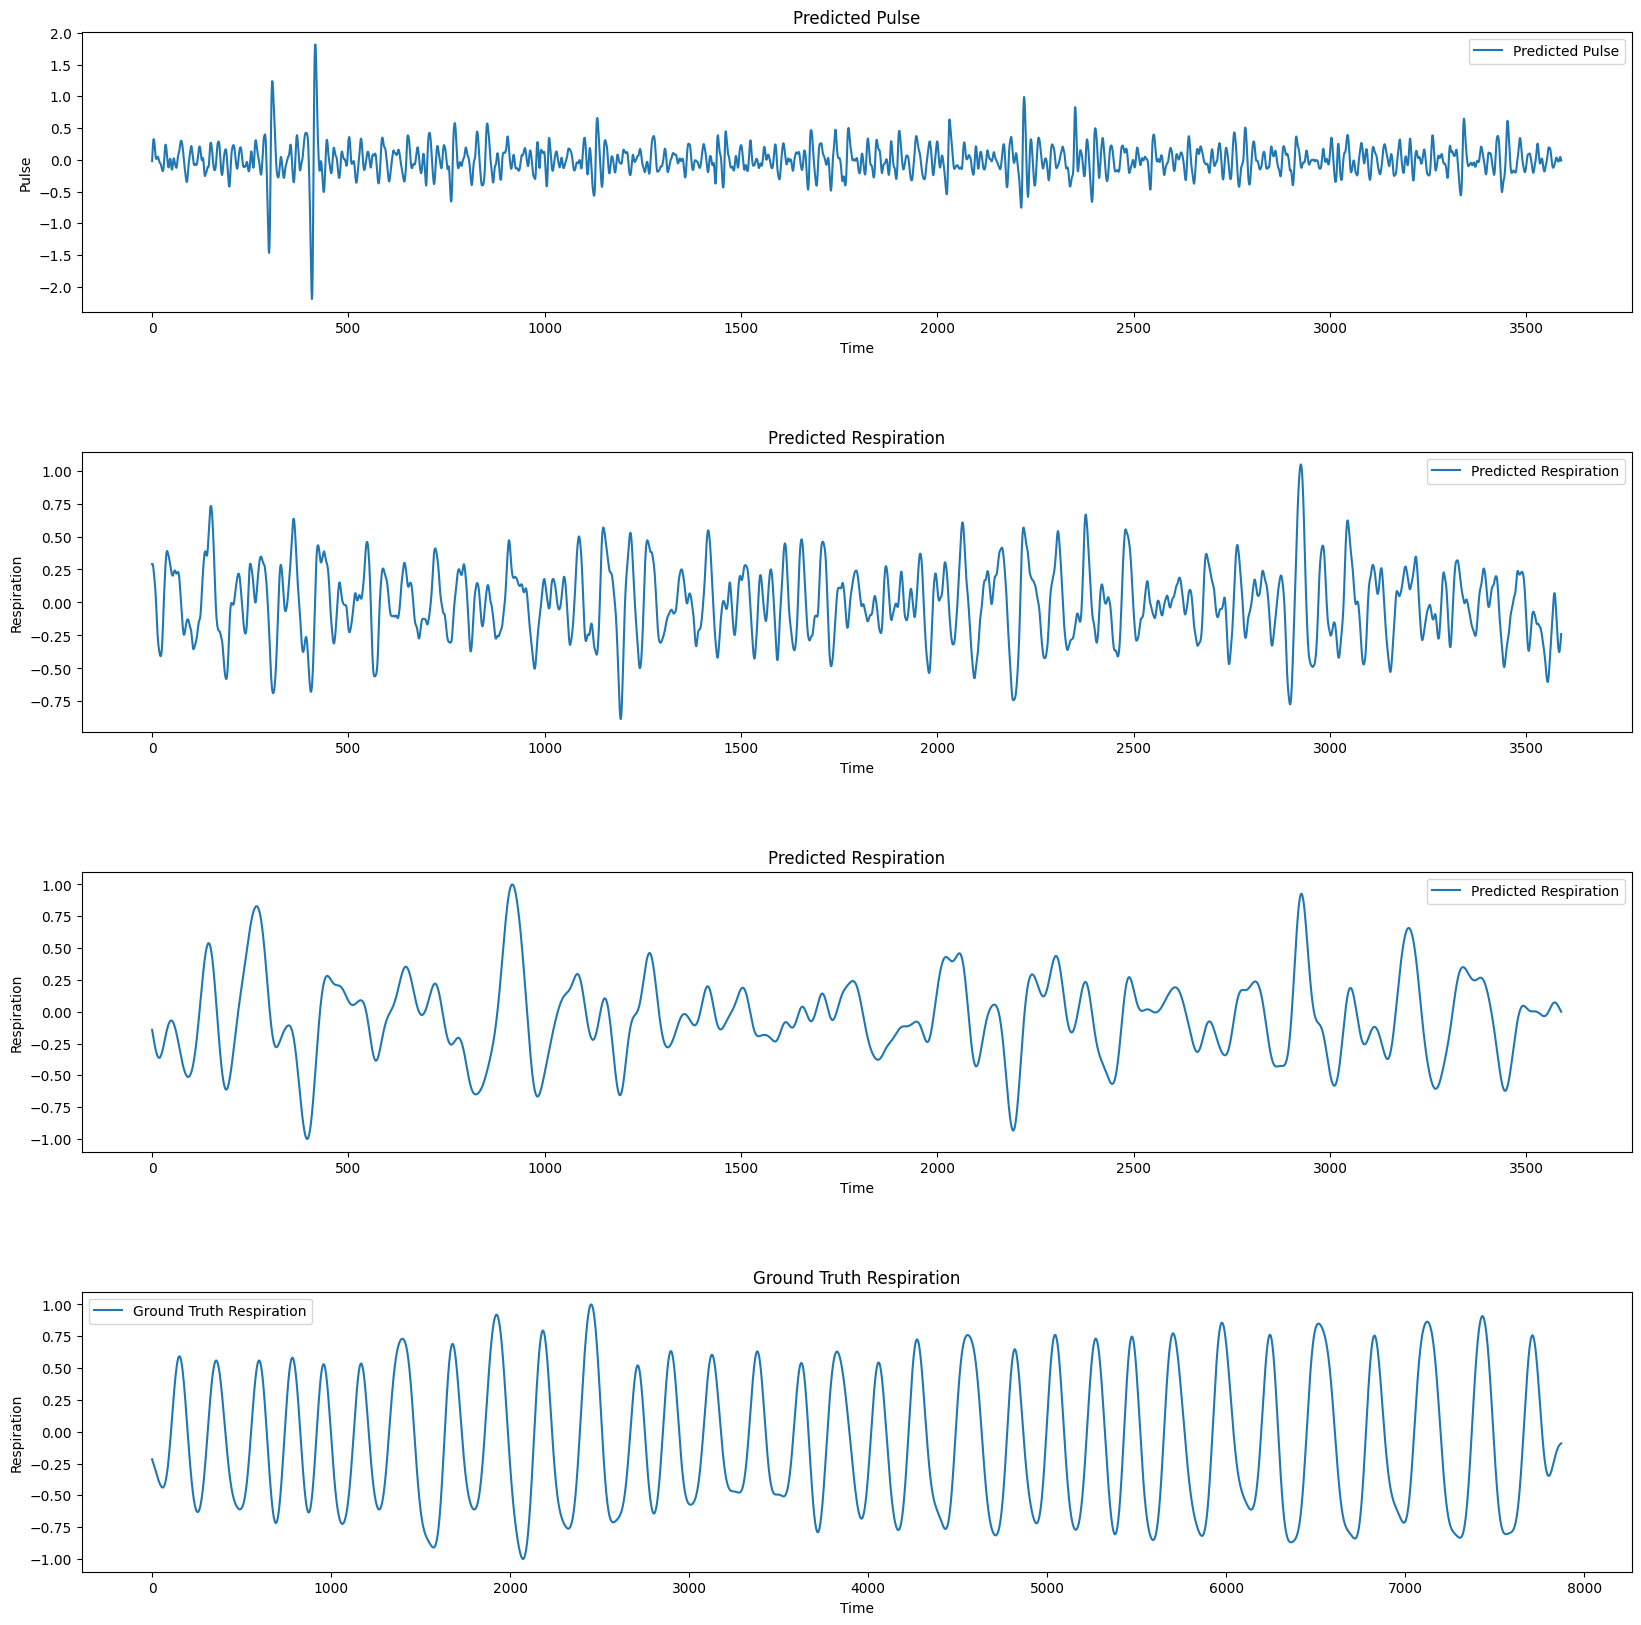

In [10]:
import respiration.preprocessing as sp

fig, axs = plt.subplots(4, 1, figsize=(20, 20))

# Add some space between the plots
fig.subplots_adjust(hspace=0.5)

axs[0].plot(pulse_pred, label='Predicted Pulse')
axs[0].set_title('Predicted Pulse')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Pulse')
axs[0].legend()

axs[1].plot(resp_pred, label='Predicted Respiration')
axs[1].set_title('Predicted Respiration')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Respiration')
axs[1].legend()

resp_pred_2 = np.cumsum(yptest[1])
# resp_pred_2 = detrend(resp_pred_2, 100)
resp_pred_2 = sp.standard_processing(resp_pred_2, meta.fps, 0.08, 0.6)

axs[2].plot(resp_pred_2, label='Predicted Respiration')
axs[2].set_title('Predicted Respiration')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Respiration')
axs[2].legend()

gt_signal, gt_sample_rate = dataset.get_ground_truth_rr_signal(subject, scenario)
gt_signal = sp.standard_processing(gt_signal, gt_sample_rate, 0.08, 0.6)

axs[3].plot(gt_signal, label='Ground Truth Respiration')
axs[3].set_title('Ground Truth Respiration')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Respiration')
axs[3].legend()

In [11]:
from respiration.analysis import FrequencyExtractor

gt_fe = FrequencyExtractor(gt_signal, gt_sample_rate, lowpass=0.08, highpass=0.6)
pd_fe = FrequencyExtractor(resp_pred_2, meta.fps, lowpass=0.08, highpass=0.6)

gt_bpm = gt_fe.frequency_from_nfcp() * 60
pd_bpm = pd_fe.frequency_from_nfcp() * 60

abs(gt_bpm - pd_bpm)

7.474692574223795

In [14]:
import scipy.stats as stats
from scipy.signal import resample
from scipy.spatial import distance

# Resample the ground truth signal to the length of the predicted signal
resampled_gt = resample(gt_signal, len(resp_pred_2))

# Calculate the mean squared error
mse = np.mean((resampled_gt - resp_pred_2) ** 2)

# Calculate the Euclidean distance
euclidean_distance = distance.euclidean(resampled_gt, resp_pred_2)

# Calculate the Pearson correlation
p_correlation, _ = stats.pearsonr(resampled_gt, resp_pred_2)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Euclidean Distance: {euclidean_distance:.2f}')
print(f'Pearson Correlation: {p_correlation:.2f}')

Mean Squared Error: 0.41
Euclidean Distance: 38.24
Pearson Correlation: -0.06
